# Detection Network Trainer

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import DetectorNetwork as dn

In [3]:
import os, sys, time, datetime, random
from pathlib import Path
from warnings import warn
from tqdm import tqdm, tnrange, tqdm_notebook
import pickle as pkl
import gc

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from collections import Counter, OrderedDict
import cv2
from PIL import Image

In [4]:
import torch as t
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import torchvision as tv
from torch import optim

In [5]:
mpl.rcParams.update({'font.size': 14})
CMAP = plt.get_cmap('rainbow')

## RPN training (freezed convolutional base)

In this part we try to use the features from the pretrained Resnet network as constants, and improve the network by only training its RPN (Regions Proposal Network) head.

We also ignore the dark image for a start.

#### Load images, labels and convolutional networks

In [6]:
DARK_IMAGES = ('20190620_213113_17.png',)
ADD_LOCATION_FEATURES = False
OBJ_OVERWEIGHT = 2
LAB_OVERWEIGHT = 5 * 2 / (1+OBJ_OVERWEIGHT)

In [7]:
files, images, W, H = dn.get_training_images(filter_list=DARK_IMAGES)

labels, locations, anchors = dn.get_training_labels(keep_ids=np.array([i for i,f in enumerate(files) if f not in DARK_IMAGES]))

conv = dn.get_resnet_conv_model()
dn.set_grad(conv, 0)

features = []
for file,image in tqdm_notebook(zip(files,images),total=len(files)):
    if file in DARK_IMAGES:
        print(f'Dark image filtered:\t{file:s}')
    else:
        print(f'Image being processed:\t{file:s}')
        ft, _, map_h, map_w, feature_size = dn.get_features(image, conv, verbose=file==files[0])
        features.append(ft)

# add location to faeture map (location is informative since all images are similarly positioned)
if ADD_LOCATION_FEATURES:
    features = dn.add_location_to_features(features, anchors)

Image shape: 1920 1080
(291600, 9) (291600, 4, 9) (291600, 4)
Param-groups to set grad for: 48


Image being processed:	20190520_105429_1080.png
Pre shape,mean,std torch.Size([1, 3, 1080, 1920]) tensor(133.2651) tensor(51.7660)
Post shape,mean,std torch.Size([1, 3, 1080, 1920]) tensor(0.4490) tensor(0.2284)
Feature-map shape: torch.Size([1, 128, 135, 240])
Feature size: 8
Image being processed:	20190529_154953_1877.png
Image being processed:	20190608_155249_shavuot.eve_1876.png
Image being processed:	20190612_124811_1776.png
Image being processed:	20190612_165539_2771.png
Image being processed:	20190616_085753_1170.png
Image being processed:	20190616_192718_349.png
Image being processed:	20190620_170634_5.png
Image being processed:	20190622_094921_36.png



#### Build RPN

In [8]:
loc_fac = dn.LocationFactory(anchors, H, W)
head = dn.RPN(features=features[0], loc_features=ADD_LOCATION_FEATURES)
head.initialize_params()
dn.set_grad(head, 1)

Network channels: 128 -> 128 -> 256 -> 45
Param-groups to set grad for: 8


In [9]:
features, labels, locations = dn.to_device(head, features, labels, locations)

cuda:0


In [10]:
head_optimizer = optim.Adam(head.parameters())

[Epoch 1/10: Validation Image] No scores above threshold. Largest score: 0.003/0.500
[Epoch 4/10: Train Image] No scores above threshold. Largest score: 0.001/0.500
[Epoch 4/10: Validation Image] No scores above threshold. Largest score: 0.017/0.500
[Epoch 7/10: Train Image] No scores above threshold. Largest score: 0.143/0.500
[Epoch 7/10: Validation Image] No scores above threshold. Largest score: 0.118/0.500
[Epoch 10/10: Train Image] No scores above threshold. Largest score: 0.116/0.500
[Epoch 10/10: Validation Image] No scores above threshold. Largest score: 0.115/0.500



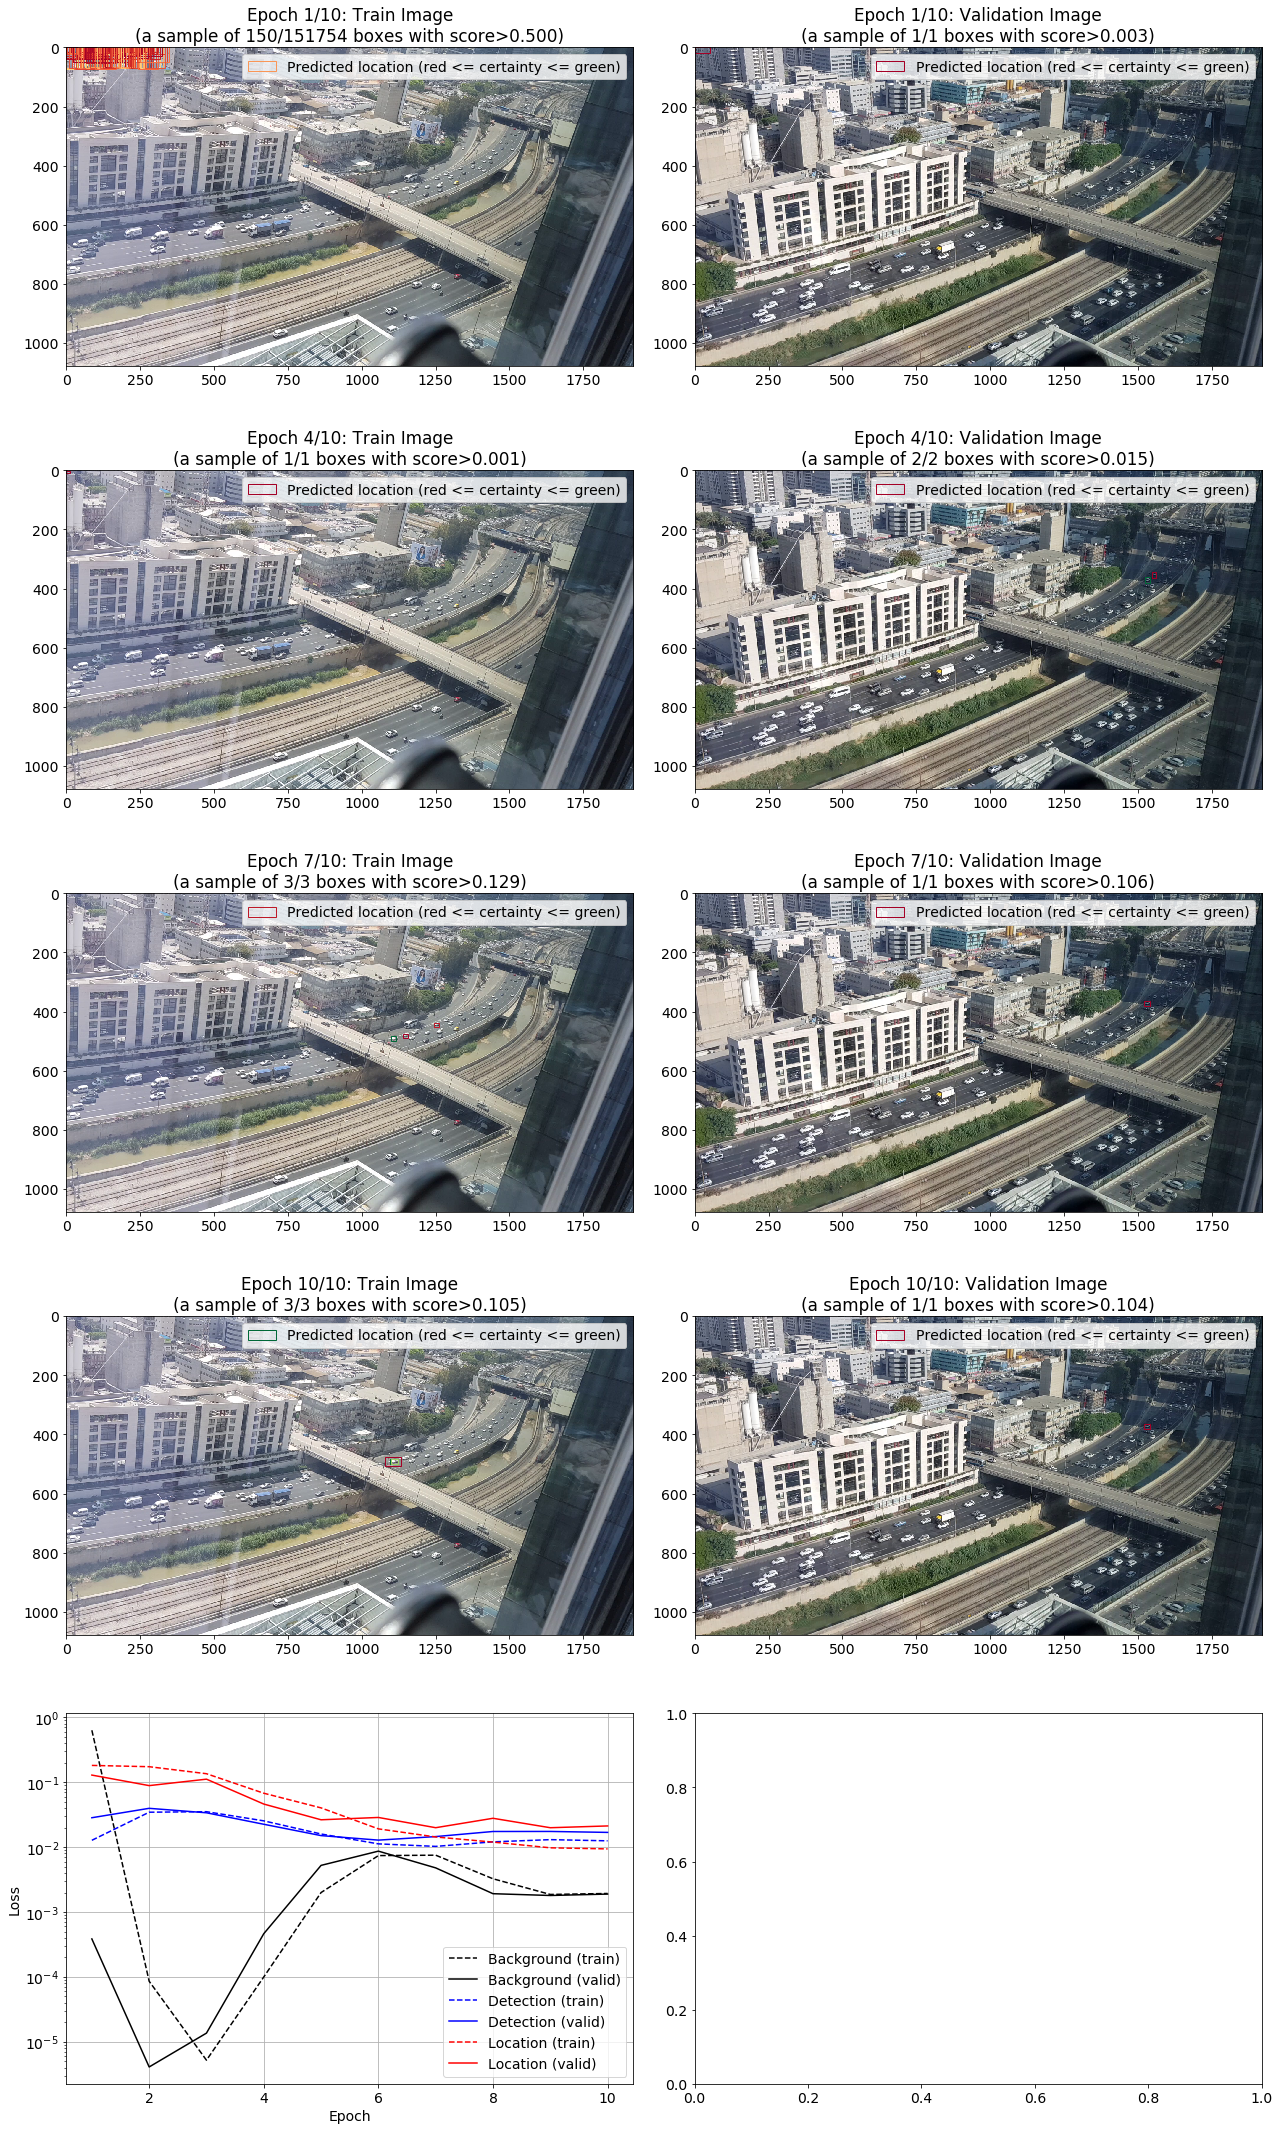

In [11]:
losses = \
    dn.train_model(head, head_optimizer, images, features, labels, locations, loc_fac, anchors=None,
                   epochs=10, lr=0.003, lab2loc_loss_ratio=LAB_OVERWEIGHT, object_overweight=OBJ_OVERWEIGHT,
                   i_train=list(range(7)), verbose=1, plot_freq=3)

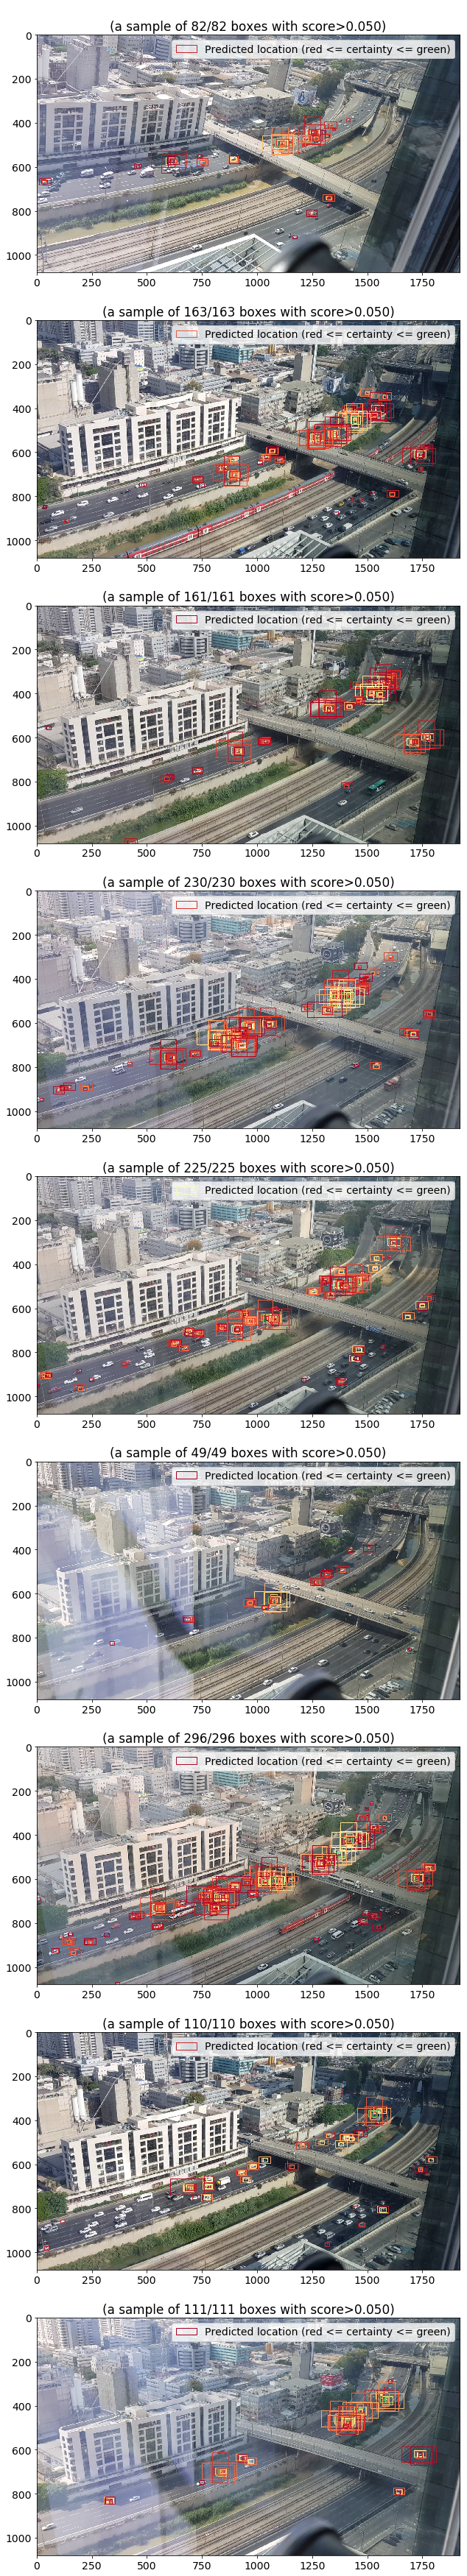

In [12]:
_,axs = plt.subplots(len(images),1, figsize=(12,len(images)*7))

for im,f,ax in tqdm_notebook(zip(images,features,axs),total=len(images)):
    with t.no_grad():
        scores, locs = head(f)
    dn.show_preds(scores, locs, loc_fac, image=im, thresh=0.05, ax=ax, n_display=np.inf)

In [13]:
gc.collect()
t.cuda.empty_cache()

## Full Network Training